In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [21]:
arma_data = {'braidwood_covid':["./Output_Braidwood_2012_2021_DA_periodic/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'braidwood_non_covid':["./Output_Braidwood_2012_2019_DA/synthetic.csv", "../data/electricity_markets/PJM_braidwood/"],
              'davis_besse':["./Output_davis_besse_2012_2021_DA/synthetic.csv", "../data/electricity_markets/PJM_davis_besse/"], 
              'ginna':["./Output_ginna_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_ginna/"],
              'fitzpatrick':["./Output_fitzpatrick_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_fitzpatrick/"],
              'nine_mile_point':["./Output_nine_mile_point_2012_2021_DA/synthetic.csv", "../data/electricity_markets/NYISO_nine_mile_point/"],
              'houston':["./Output_houston_2012_2021_DA/synthetic.csv", "../data/electricity_markets/ERCOT_houston/"]}


case = "fitzpatrick"


if case not in arma_data.keys():
  raise KeyError("{}, Case not in dictionary".format(case))
filename = arma_data[case][0]
data_dir = arma_data[case][1]

synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
synthetic_df

,hour,Year,synthetic price
0,1,2012,27.154638
1,1,2013,25.229323
2,1,2014,40.821004
3,1,2015,10.292849
4,1,2016,1.375192
...,...,...,...
332847,8760,2017,82.522237
332848,8760,2018,31.841187
332849,8760,2019,9.260417
332850,8760,2020,12.319768


In [22]:
# Get year list from synthetic data
years_list  = synthetic_df.Year.unique()
print(years_list)
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  if f.endswith('csv'):
    year = int(f.split('_')[0])
    if year in years_list:
      file = data_dir+f
      df = pd.read_csv(file)
      df['Year'] = [year for i in range(len(df))]
      li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


,historical price,hour,Year
0,28.15,1,2012
1,26.62,2,2012
2,24.17,3,2012
3,23.28,4,2012
4,22.89,5,2012
...,...,...,...
87595,76.49,8756,2013
87596,64.40,8757,2013
87597,54.10,8758,2013
87598,48.10,8759,2013


Merge historical and synthetic data

In [23]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,historical price,hour,Year,synthetic price
0,28.15,1,2012,27.154638
1,26.62,2,2012,19.149977
2,24.17,3,2012,20.162865
3,23.28,4,2012,14.824850
4,22.89,5,2012,21.305382
...,...,...,...,...
87595,76.49,8756,2013,109.320050
87596,64.40,8757,2013,37.853866
87597,54.10,8758,2013,87.243468
87598,48.10,8759,2013,23.295035


In [24]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)
stats_df

,historical price,synthetic price
count,87600.000000,87600.000000
mean,27.345601,27.353442
std,21.887493,21.911831
min,-94.520000,-94.520000
25%,16.450000,16.400939
50%,24.110000,24.095939
75%,32.770000,32.821289
max,526.030000,526.030000
kurtosis,75.953395,75.938545
skewness,6.576840,6.567068


In [25]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,28.150000
1,historical,26.620000
2,historical,24.170000
3,historical,23.280000
4,historical,22.890000
...,...,...
332847,synthetic,82.522237
332848,synthetic,31.841187
332849,synthetic,9.260417
332850,synthetic,12.319768


526.03 32.77 16.45 -94.52


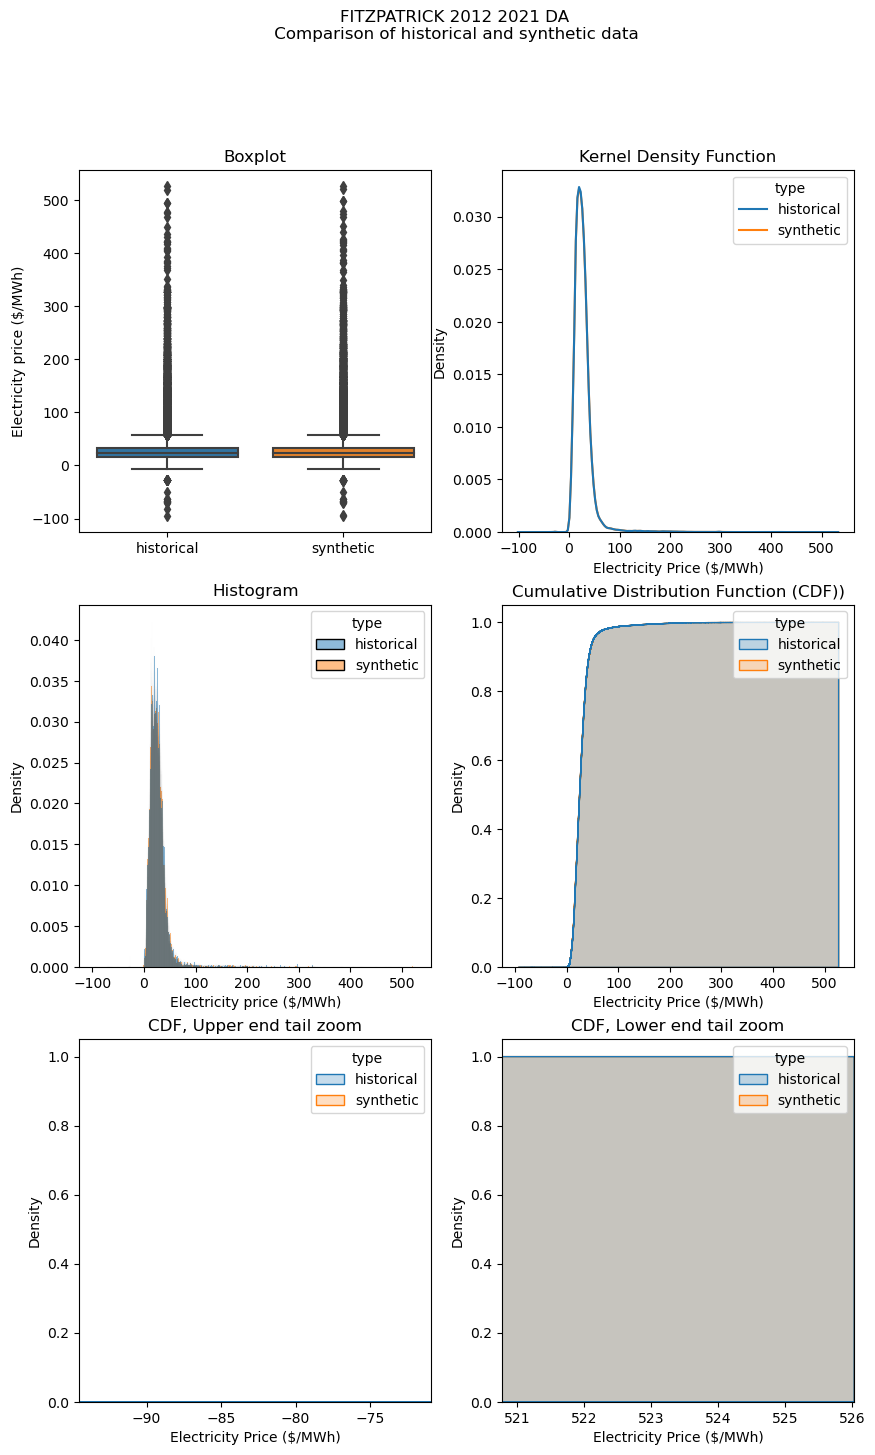

In [26]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(3,2,figsize =(10,16))

title = ' '.join(tag.split('_')).upper()+'\n Comparison of historical and synthetic data'
fig.suptitle(title)

sns.boxplot(ax = axes[0,0],data=prices_df, x='type', y='price')
axes[0,0].set_title('Boxplot')
axes[0,0].set_ylabel('Electricity price ($/MWh)')
axes[0,0].set_xlabel('')

sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=5000, stat='density', common_norm=False)
axes[1,0].set_title('Histogram')
axes[1,0].set_xlabel('Electricity price ($/MWh)')
#axes[1,0].set_xlim(-25,200)

sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type',common_norm=False)
axes[0,1].set_title('Kernel Density Function')
axes[0,1].set_xlabel('Electricity Price ($/MWh)')
#axes[0,1].set_xlim(-25,200)

sns.histplot(ax = axes[1,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[1,1].set_title('Cumulative Distribution Function (CDF))')
axes[1,1].set_xlabel('Electricity Price ($/MWh)')
#axes[1,1].set_xlim(0,125)

max_price = stats['historical price']['max']
quart1_price = stats['historical price']['25%']
min_price = stats['historical price']['min']
quart3_price = stats['historical price']['75%']
print(max_price, quart3_price, quart1_price, min_price)

sns.histplot(ax = axes[2,0], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[2,0].set_title('CDF, Upper end tail zoom')
axes[2,0].set_xlabel('Electricity Price ($/MWh)')
axes[2,0].set_xlim(min_price,max(0.75*min_price, 1.25*min_price))

sns.histplot(ax = axes[2,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[2,1].set_title('CDF, Lower end tail zoom')
axes[2,1].set_xlabel('Electricity Price ($/MWh)')
axes[2,1].set_xlim(0.99*max_price,max_price)

fig.savefig(tag+'_comparison_plots.png')

